In [1]:
"""
    Global imports and variables
"""

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn
import theano

from catch import Catch

from keras import backend as K
from keras.layers import Input
from keras.layers.core import Dense, Flatten, Reshape, Lambda
from keras.layers.convolutional import Conv2D
from keras.models import Model
from keras.optimizers import RMSprop



nb_runs_each = 5
nb_episodes = 500
min_replay_size = 100
y_eval = 0.99

/Users/alexpiche/miniconda2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
Using Theano backend.


In [2]:
"""
    Experience replay implemented by Josh Romoff
"""

class Replay(object):
    def __init__(self, max_size, state_shape):
        self.index = 0
        self.size = 0
        self.max_size = max_size
        self.state_shape = state_shape
        self.s = np.zeros([max_size] + state_shape, dtype='float32')
        self.a = np.zeros(max_size, dtype='int32')
        self.r = np.zeros(max_size, dtype='float32')
        self.s2 = np.zeros([max_size] + state_shape, dtype='float32')
        self.t = np.zeros(max_size, dtype='float32')
        
    def sample_batch(self, batch_size):
        indices = np.random.randint(low=0, high=self.size, size=batch_size)
        return self.s[indices], self.a[indices], self.r[indices], self.s2[indices], self.t[indices]
    
    def add_transition(self, s, a, r, s2, t):
        s = s.reshape(self.state_shape)
        s2 = s2.reshape(self.state_shape)
        self.s[self.index % self.max_size] = s
        self.a[self.index % self.max_size] = a
        self.r[self.index % self.max_size] = r
        self.s2[self.index % self.max_size] = s2
        self.t[self.index % self.max_size] = t
        self.index += 1
        self.size = min(self.index, self.max_size)

In [3]:
class DQN(object):
    def __init__(self, env, lr=0.001, batch_size=32):
        self.state_shape = env.state_shape
        self.nb_actions = env.nb_actions
        self.lr = lr
        self.batch_size = batch_size
        self.replay = Replay(max_size=10000, state_shape=self.state_shape)
        self.network = self._build_network(self.state_shape, self.nb_actions)
        self._compile(self.state_shape, self.nb_actions)
        
    def _build_network(self, state_shape, nb_actions):
        input_dim = tuple(state_shape)
        states = Input(shape=input_dim, dtype='float32', name='states')
        conv = Conv2D(kernel_initializer="he_uniform", activation="relu",
                             padding="same", strides=(1, 1), filters=16, kernel_size=(3, 3))(states)
        flatten = Flatten()(conv)
        dense = Dense(units=128, activation="relu", kernel_initializer="he_uniform")(flatten)
    
        out = Dense(units=nb_actions, activation="linear", kernel_initializer="he_uniform")(dense)
    
        return Model(inputs=states, outputs=out)

    def _compile(self, state_shape, nb_actions):
        # Inputs
        y = 0.99
        s = K.placeholder(shape=tuple([None] + state_shape))
        a = K.placeholder(ndim=1, dtype='int32')
        r = K.placeholder(ndim=1, dtype='float32')
        s2 = K.placeholder(shape=tuple([None] + state_shape))
        t = K.placeholder(ndim=1, dtype='float32')

        # Q(s, a) for each agent
        q = self.network(s) # q has shape (batch_size, nb_actions)
        preds = q[K.T.arange(s.shape[0]), a]
    

        # r + (1 - t) * gamma * max_a(Q'(s')) for each agent
        q2 = self.network(s2)
        q2_max = K.max(q2, axis=1)
        targets = r + (K.cast_to_floatx(1) - t) * y * q2_max

        # Loss and Updates
        cost = K.sum(0.5 * (targets - preds) ** 2) 
        optimizer = RMSprop(lr=self.lr, rho=.95, epsilon=1e-7)
        updates = optimizer.get_updates(params=self.network.trainable_weights, loss=cost, constraints={})

        # Compiled Functions
        self._train = K.function(inputs=[s, a, r, s2, t], outputs=[cost], updates=updates)
        self._predict = K.function(inputs=[s], outputs=q)

    def get_action(self, state, epsilon):
        state = np.expand_dims(state.reshape(self.state_shape), axis=0)
        if np.random.binomial(1, epsilon):
            return np.random.randint(self.nb_actions)
        else:
            q = self._predict([state])
            return np.argmax(q)
        
    def learn(self):
        s, a, r, s2, t = self.replay.sample_batch(self.batch_size)
        return self._train([s, a, r, s2, t])

# Double DQN

* DQN tends to overestimate the Q-values
* Use a target network to generate the Q-values, while the main network is used to choose actions.
* The target network is kept fixed for several iterations before being updated with the weights of the main network

In [4]:
class doubleDQN(object):
    def __init__(self, env, lr=0.001, batch_size=32):
        self.state_shape = env.state_shape
        self.nb_actions = env.nb_actions
        self.lr = lr
        self.batch_size = batch_size
        self.replay = Replay(max_size=10000, state_shape=self.state_shape)
        self.network = self._build_network(self.state_shape, self.nb_actions)
        self._compile(self.state_shape, self.nb_actions)
        
    def _build_network(self, state_shape, nb_actions):
        input_dim = tuple(state_shape)
        
        states = Input(shape=input_dim, dtype='float32', name='states')
        
        conv = Conv2D(kernel_initializer="he_uniform", activation="relu",
                             padding="same", strides=(1, 1), filters=16, kernel_size=(3, 3))(states)
        
        flatten = Flatten()(conv)
        
        dense = Dense(units=128, activation="relu", kernel_initializer="he_uniform")(flatten)
    
        out = Dense(units=nb_actions, activation="linear", kernel_initializer="he_uniform")(dense)
    
        return Model(inputs=states, outputs=out)

    def _compile(self, state_shape, nb_actions):
        # Inputs
        y = 0.99
        s = K.placeholder(shape=tuple([None] + state_shape))
        a = K.placeholder(ndim=1, dtype='int32')
        r = K.placeholder(ndim=1, dtype='float32')
        s2 = K.placeholder(shape=tuple([None] + state_shape))
        t = K.placeholder(ndim=1, dtype='float32')

        # Q(s, a) for each agent
        q = self.network(s) # q has shape (batch_size, nb_actions)
        preds = q[K.T.arange(s.shape[0]), a]
    

        # r + (1 - t) * gamma * max_a(Q'(s')) for each agent
        q2 = theano.gradient.disconnected_grad(self.network(s2))
        q2_max = K.max(q2, axis=1)
        targets = r + (K.cast_to_floatx(1) - t) * y * q2_max

        # Loss and Updates
        cost = K.sum(0.5 * (targets - preds) ** 2) 
        optimizer = RMSprop(lr=self.lr, rho=.95, epsilon=1e-7)
        updates = optimizer.get_updates(params=self.network.trainable_weights, loss=cost, constraints={})

        # Compiled Functions
        self._train = K.function(inputs=[s, a, r, s2, t], outputs=[cost], updates=updates)
        self._predict = K.function(inputs=[s], outputs=q)

    def get_action(self, state, epsilon):
        state = np.expand_dims(state.reshape(self.state_shape), axis=0)
        if np.random.binomial(1, epsilon):
            return np.random.randint(self.nb_actions)
        else:
            q = self._predict([state])
            return np.argmax(q)
        
    def learn(self):
        s, a, r, s2, t = self.replay.sample_batch(self.batch_size)
        return self._train([s, a, r, s2, t])

# Dueling DQN

* We can express the Q-value as the sum of the value of the state and the advantage function, which tells how much better the action is than the other.

\begin{eqnarray}
Q(s,a) &=& V(s) + A(a)
\end{eqnarray}

* It is more stable to estimate these two values and put them together.
* In practice we also use the average advantage values as a baseline to reduce variance.

In [5]:
class duelingDQN(object):
    def __init__(self, env, lr=0.001, batch_size=32):
        self.state_shape = env.state_shape
        self.nb_actions = env.nb_actions
        self.lr = lr
        self.batch_size = batch_size
        self.replay = Replay(max_size=10000, state_shape=self.state_shape)
        self.network = self._build_network(self.state_shape, self.nb_actions)
        self._compile(self.state_shape, self.nb_actions)
        
    def _build_network(self, state_shape, nb_actions):
        input_dim = tuple(state_shape)
        
        states = Input(shape=input_dim, dtype='float32', name='states')
        
        conv = Conv2D(kernel_initializer="he_uniform", activation="relu",
                             padding="same", strides=(1, 1), filters=16, kernel_size=(3, 3))(states)
        
        flatten = Flatten()(conv)
        
        dense = Dense(units=128, activation="relu", kernel_initializer="he_uniform")(flatten)
        
        advantage_value = Dense(units=self.nb_actions+1, kernel_initializer='he_uniform',
                      activation='linear')(dense)


        out = Lambda(lambda a: K.expand_dims(a[:, 0]) + a[:, 1:] - K.mean(a[:, 1:], keepdims=True),
                   output_shape=(self.nb_actions,))(advantage_value)
    
        return Model(inputs=states, outputs=out)

    def _compile(self, state_shape, nb_actions):
        # Inputs
        y = 0.99
        s = K.placeholder(shape=tuple([None] + state_shape))
        a = K.placeholder(ndim=1, dtype='int32')
        r = K.placeholder(ndim=1, dtype='float32')
        s2 = K.placeholder(shape=tuple([None] + state_shape))
        t = K.placeholder(ndim=1, dtype='float32')

        q = self.network(s) # q has shape (batch_size, nb_actions)
        preds = q[K.T.arange(s.shape[0]), a]
    

        # r + (1 - t) * gamma * max_a(Q'(s')) for each agent
        q2 = self.network(s2)
        q2_max = K.max(q2, axis=1)
        targets = r + (K.cast_to_floatx(1) - t) * y * q2_max

        # Loss and Updates
        cost = K.sum(0.5 * (targets - preds) ** 2) 
        optimizer = RMSprop(lr=self.lr, rho=.95, epsilon=1e-7)
        updates = optimizer.get_updates(params=self.network.trainable_weights, loss=cost, constraints={})

        # Compiled Functions
        self._train = K.function(inputs=[s, a, r, s2, t], outputs=[cost], updates=updates)
        self._predict = K.function(inputs=[s], outputs=q)

    def get_action(self, state, epsilon):
        state = np.expand_dims(state.reshape(self.state_shape), axis=0)
        if np.random.binomial(1, epsilon):
            return np.random.randint(self.nb_actions)
        else:
            q = self._predict([state])
            return np.argmax(q)
        
    def learn(self):
        s, a, r, s2, t = self.replay.sample_batch(self.batch_size)
        return self._train([s, a, r, s2, t])

In [6]:
class doubleDuelingDQN(object):
    def __init__(self, env, lr=0.001, batch_size=32):
        self.state_shape = env.state_shape
        self.nb_actions = env.nb_actions
        self.lr = lr
        self.batch_size = batch_size
        self.replay = Replay(max_size=10000, state_shape=self.state_shape)
        self.network = self._build_network(self.state_shape, self.nb_actions)
        self._compile(self.state_shape, self.nb_actions)
        
    def _build_network(self, state_shape, nb_actions):
        input_dim = tuple(state_shape)
        
        states = Input(shape=input_dim, dtype='float32', name='states')
        
        conv = Conv2D(kernel_initializer="he_uniform", activation="relu",
                             padding="same", strides=(1, 1), filters=16, kernel_size=(3, 3))(states)
        
        flatten = Flatten()(conv)
        
        dense = Dense(units=128, activation="relu", kernel_initializer="he_uniform")(flatten)
        
        advantage_value = Dense(units=self.nb_actions+1, kernel_initializer='he_uniform',
                      activation='linear')(dense)


        out = Lambda(lambda a: K.expand_dims(a[:, 0]) + a[:, 1:] - K.mean(a[:, 1:], keepdims=True),
                   output_shape=(self.nb_actions,))(advantage_value)
    
        return Model(inputs=states, outputs=out)

    def _compile(self, state_shape, nb_actions):
        # Inputs
        y = 0.99
        s = K.placeholder(shape=tuple([None] + state_shape))
        a = K.placeholder(ndim=1, dtype='int32')
        r = K.placeholder(ndim=1, dtype='float32')
        s2 = K.placeholder(shape=tuple([None] + state_shape))
        t = K.placeholder(ndim=1, dtype='float32')

        q = self.network(s) # q has shape (batch_size, nb_actions)
        preds = q[K.T.arange(s.shape[0]), a]
    

        # r + (1 - t) * gamma * max_a(Q'(s')) for each agent
        q2 = theano.gradient.disconnected_grad(self.network(s2))
        q2_max = K.max(q2, axis=1)
        targets = r + (K.cast_to_floatx(1) - t) * y * q2_max

        # Loss and Updates
        cost = K.sum(0.5 * (targets - preds) ** 2) 
        optimizer = RMSprop(lr=self.lr, rho=.95, epsilon=1e-7)
        updates = optimizer.get_updates(params=self.network.trainable_weights, loss=cost, constraints={})

        # Compiled Functions
        self._train = K.function(inputs=[s, a, r, s2, t], outputs=[cost], updates=updates)
        self._predict = K.function(inputs=[s], outputs=q)

    def get_action(self, state, epsilon):
        state = np.expand_dims(state.reshape(self.state_shape), axis=0)
        if np.random.binomial(1, epsilon):
            return np.random.randint(self.nb_actions)
        else:
            q = self._predict([state])
            return np.argmax(q)
        
    def learn(self):
        s, a, r, s2, t = self.replay.sample_batch(self.batch_size)
        return self._train([s, a, r, s2, t])

In [7]:
def experiment(nb_runs_each, nb_episodes, min_replay_size, mult_gammas, y_eval=0.99):
    env = Catch()
    models = [DQN, doubleDQN, duelingDQN, doubleDuelingDQN]
    all_agent_rewards = np.empty((nb_runs_each, nb_episodes, len(models)))

    for model_index, model in enumerate(models):
        print "Model" + str(model_index)
        for run in range(nb_runs_each):   
            agent = model(env)
            for ep in range(nb_episodes):
                rewards = 0
                env.reset()
                terminal = False
                while not terminal:
                    s = env.observe()
                    a = agent.get_action(s, epsilon=0.1)
                    s2, r, terminal = env.act(a)
                    agent.replay.add_transition(s, a, r, s2, terminal)
                    if agent.replay.size > min_replay_size:
                        agent.learn()
                    rewards += r
                all_agent_rewards[run, ep, model_index] = rewards
                
    return all_agent_rewards

In [8]:
rewards = experiment(nb_runs_each, nb_episodes,  min_replay_size, mult_gammas=True)

with open('rewards', 'wb') as f:
    pickle.dump(rewards, f)


/Users/alexpiche/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  del sys.path[0]
/Users/alexpiche/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  
/Users/alexpiche/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  from ipykernel import kernelapp as app
/Users/alexpiche/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  app.launch_new_instance()


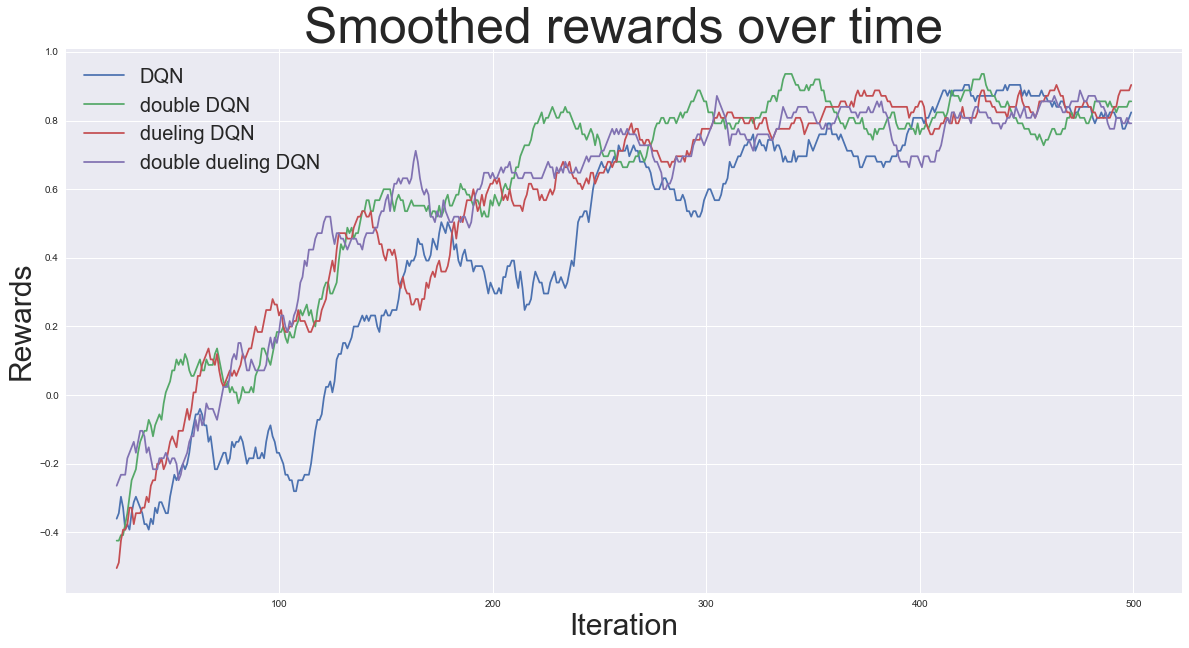

In [12]:
"""
Plot the average rewards for each model
"""


with open('rewards', 'rb') as f:
     rewards = pickle.load(f)

rewards = np.mean(rewards, axis=0)

fig = plt.figure(figsize=(20, 10))

_DQN, = plt.plot(pd.rolling_mean(rewards[:,0],25), label="DQN")
double_DQN, = plt.plot(pd.rolling_mean(rewards[:,1],25), label="double DQN")
duel_DQN, = plt.plot(pd.rolling_mean(rewards[:,2],25), label="dueling DQN")
double_duel_DQN, = plt.plot(pd.rolling_mean(rewards[:,3],25), label="double dueling DQN")


plt.title("Smoothed rewards over time", fontsize=50)
ax = fig.add_subplot(111)
ax.set_xlabel('Iteration', fontsize = 30)
ax.set_ylabel('Rewards', fontsize = 30)

plt.legend(handles=[_DQN, double_DQN, duel_DQN, double_duel_DQN], fontsize = 20)
plt.show()
